In [1]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import pathlib
import itertools
import glob
import json

In [2]:
import monalysa
from monalysa import movements
from monalysa import quality

In [3]:
# Define the font family and size
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica']
plt.rcParams['font.weight'] = 'light'  # Use 'light' font weight

In [4]:
base_fig_dir = pathlib.Path.cwd().parent / "figures"

## Demonstration of the duration of movement

In [6]:
_t, _vel, _ = movements.generate_random_movement(move_type='Gaussian')
vel1 = np.hstack((np.zeros(40), _vel, np.zeros(25)))
dt = 0.01
T = len(vel1) * dt
t = np.arange(0, T, dt)
pos1 = 1.0 + np.cumsum(vel1) * dt

# Movement interval
epsilon = 0.1
_mi = 1.0* (vel1 > epsilon)
_tstrt = np.where(np.diff(_mi) == 1)[0]
_tstp = np.where(np.diff(_mi) == -1)[0]

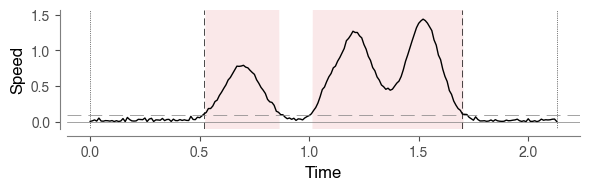

In [40]:
fig = plt.figure(figsize=(6, 2))

# Velocity plot
ax = fig.add_subplot(111)
ax.plot(t, vel1 + np.abs(0.025 * np.random.randn(len(vel1))), color='black', lw=1)
ax.fill(t, 10 * _mi - 5, color='tab:red', lw=0, alpha=0.1)
ax.axvline(t[_tstrt[0]], color='black', lw=0.5, ls="dashed", dashes=(10, 5))
ax.axvline(t[_tstp[-1]], color='black', lw=0.5, ls="dashed", dashes=(10, 5))
ax.axvline(0, color='black', lw=0.5, ls="dotted")
ax.axvline(t[-1], color='black', lw=0.5, ls="dotted")
ax.axhline(epsilon, color='tab:gray', lw=0.5, ls="dashed", dashes=(20, 10))
ax.axhline(0, color='tab:gray', lw=0.5)
ax.set_ylim(-0.1, 1.1 * max(vel1))
# ax.set_xlim(-0.1, 3.0)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_position(('outward', 5))
ax.spines['bottom'].set_position(('outward', 5))
ax.spines['left'].set_color("tab:gray")
ax.spines['bottom'].set_color("tab:gray")
ax.tick_params(axis='x', colors='0.3')
ax.tick_params(axis='y', colors='0.3')
ax.set_ylabel("Speed", fontsize=12)
ax.set_xlabel("Time", fontsize=12)
plt.tight_layout()

# Save figure
fig.savefig(pathlib.Path(base_fig_dir, f"duration_demo.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(base_fig_dir, f"duration_demo.svg"), bbox_inches="tight")


## Demonstration of Spatiotemporal Distance 

In [78]:
moves = {}

# Case 1
dt = 0.01
t1 = np.arange(0, 1 + dt, dt)
t2 = np.arange(0, 1.5 + dt, dt)
m1 = np.cumsum(movements.mjt_discrete_movement(amp=1, dur=1.0, loc=0.5, time=t1, data_type="vel")) * dt
m1_hat = np.cumsum(movements.mjt_discrete_movement(amp=1, dur=1.0, loc=0.5, time=t2, data_type="vel")) * dt
m2 = np.cumsum(movements.mjt_discrete_movement(amp=1, dur=1.5, loc=0.75, time=t2, data_type="vel")) * dt
m2 += 0 * np.random.normal(0, 0.5, len(m1_hat))
# m2 = np.abs(signal.savgol_filter(m2, window_length=21, polyorder=1, mode="constant"))
moves['case1'] = {
    "t1": t1,
    "t2": t2,
    "m1": m1,
    "m1_hat": m1_hat,
    "m2": m2
}

# Case 2
t1 = np.arange(0, 1.0 + dt, dt)
t2 = np.arange(0, 2.25 + dt, dt)
m1 = np.cumsum(movements.mjt_discrete_movement(amp=1, dur=1.0, loc=0.5, time=t1, data_type="vel")) * dt
m1_hat = np.cumsum(movements.mjt_discrete_movement(amp=1, dur=1.0, loc=0.5, time=t2, data_type="vel")) * dt
m2 = (np.cumsum(movements.mjt_discrete_movement(amp=1, dur=1.0, loc=0.5, time=t2, data_type="vel")) * dt + 
      np.cumsum(movements.mjt_discrete_movement(amp=0.5, dur=1.0, loc=1.5, time=t2, data_type="vel")) * dt)
moves['case2'] = {
    "t1": t1,
    "t2": t2,
    "m1": m1,
    "m1_hat": m1_hat,
    "m2": m2,
}

# Case 3
t = np.arange(0, 1.0 + dt, dt)
m1 = np.cumsum(movements.mjt_discrete_movement(amp=1, dur=1.0, loc=0.5, time=t, data_type="vel")) * dt
m2 = m1 + 0.2 * np.cumsum(movements.mjt_discrete_movement(amp=1, dur=0.3, loc=0.85, time=t, data_type="vel")) * dt
moves['case3'] = {
    "t": t,
    "m1": m1,
    "m2": m2,
}


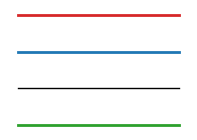

In [79]:
fig = plt.figure(figsize=(4, 1.5))
ax = fig.add_subplot(121)
ax.plot([0, 1], [1, 1], color='tab:red', lw=2, alpha=1)
ax.plot([0, 1], [0, 0], color='tab:blue', lw=2, alpha=1)
ax.plot([0, 1], [-1, -1], color='k', lw=1)
ax.plot([0, 1], [-2, -2], color='tab:green', lw=2)
ax.axis('off')
plt.tight_layout()

# Save figure
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist_legend.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist_legend.svg"), bbox_inches="tight")

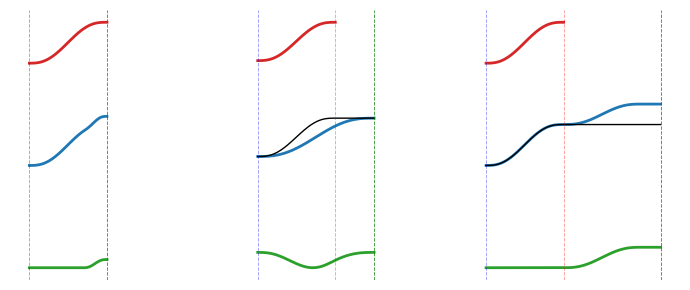

In [105]:
fig = plt.figure(figsize=(7, 3))
ax = fig.add_subplot(132)
ax.plot(moves["case1"]["t1"], moves["case1"]["m1"], color='tab:red', lw=2)
ax.plot(moves["case1"]["t2"], moves["case1"]["m2"] - 2.5, color="tab:blue", lw=2)
ax.plot(moves["case1"]["t2"], moves["case1"]["m1_hat"] - 2.5, color='k', lw=1)
ax.plot(moves["case1"]["t2"], moves["case1"]["m2"] - moves["case1"]["m1_hat"]- 5.0,
        color="tab:green", lw=2)
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.axvline(1.0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.axvline(1.5, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.set_xlim(-0.25, 2.5)
ax.axis('off')

ax = fig.add_subplot(133)
ax.plot(moves["case2"]["t1"], moves["case2"]["m1"], color='tab:red', lw=2)
ax.plot(moves["case2"]["t2"], moves["case2"]["m2"] - 2.5, color="tab:blue", lw=2)
ax.plot(moves["case2"]["t2"], moves["case2"]["m1_hat"] - 2.5, color='k', lw=1)
ax.plot(moves["case2"]["t2"], moves["case2"]["m2"] - moves["case2"]["m1_hat"]- 5.0,
        color="tab:green", lw=2)
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.axvline(1, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.axvline(2.25, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.set_xlim(-0.25, 2.5)
ax.axis('off')

ax = fig.add_subplot(131)
ax.plot(moves["case3"]["t"], moves["case3"]["m1"], color='tab:red', lw=2)
ax.plot(moves["case3"]["t"], moves["case3"]["m2"] - 2.5, color="tab:blue", lw=2)
ax.plot(moves["case3"]["t"], moves["case3"]["m2"] - moves["case2"]["m1"]- 5.0,
        color="tab:green", lw=2)
ax.axvline(0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=0.5)
ax.axvline(1.0, lw=0.5, color='k', ls="dashed", dashes=(5, 2), alpha=1.0)
ax.set_xlim(-0.25, 2.5)
ax.axis('off')

plt.tight_layout()

# Save figure
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist_plots.pdf"), bbox_inches="tight")
fig.savefig(pathlib.Path(base_fig_dir, f"st_dist_plots.svg"), bbox_inches="tight")